# Introduction

*   This notebook implements the "Sarsa" algorithm for the "CartPole-v0" environment. For more information on the environment, please visit [here](https://gym.openai.com/envs/CartPole-v0/#barto83). Also, check the related paper [here](https://ieeexplore.ieee.org/document/6313077).



*   The algorithm and the related text is copied and pasted from Section 6.4 of the book "Reinforcement Learning: An Introduction" by Richard S. Sutton and Andrew G. Barto (second edition).



*   You can download the book [here](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf).

# Sarsa: On-policy TD Control

We turn now to the use of TD prediction methods for the control problem. As usual, we follow the pattern of generalized policy iteration (GPI), only this time using TD methods for the evaluation or prediction part. As with Monte Carlo methods, we face the need to trade off exploration and exploitation, and again approaches fall into two main classes: on-policy and off-policy. In this section we present an on-policy TD control method.

The first step is to learn an action-value function rather than a state-value function. In particular, for an on-policy method we must estimate $q_{\pi}(s, a)$ for the current behavior policy $\pi$ and for all states $s$ and actions $a$. Recall that an episode consists of an alternating sequence of states and state–action pairs:

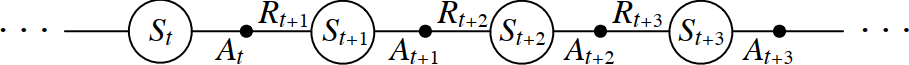

In the previous section we considered transitions from state to state and learned the values of states. Now we consider transitions from state–action pair to state–action pair, and learn the values of state–action pairs. Formally these cases are identical: they are both Markov chains with a reward process. The theorems assuring the convergence of state values under TD(0) also apply to the corresponding algorithm for action values:

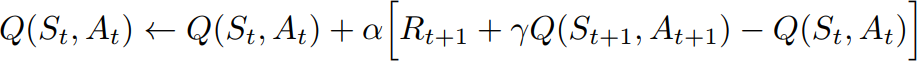

This update is done after every transition from a nonterminal state $S_{t}$. If $S_{t+1}$ is terminal, then $Q(S_{t+1}, A_{t+1})$ is defined as zero. This rule uses every element of the quintuple of events, $(S_{t}, A_{t}, R_{t+1}, S_{t+1}, A_{t+1})$, that make up a transition from one state–action pair to the next. This quintuple gives rise to the name *Sarsa* for the algorithm.

It is straightforward to design an on-policy control algorithm based on the Sarsa prediction method. As in all on-policy methods, we continually estimate $q_{\pi}$ for the behavior policy $\pi$, and at the same time change $\pi$ toward greediness with respect to $q_{\pi}$.

The convergence properties of the Sarsa algorithm depend on the nature of the policy's dependence on $Q$. For example, one could use $\epsilon$-greedy or $\epsilon$-soft policies. Sarsa converges with probability $1$ to an optimal policy and action-value function as long as all state–action pairs are visited an infinite number of times and the policy converges in the limit to the greedy policy (which can be arranged, for example, with $\epsilon$-greedy policies by setting $\epsilon = 1 / t$).

**Algorithm**

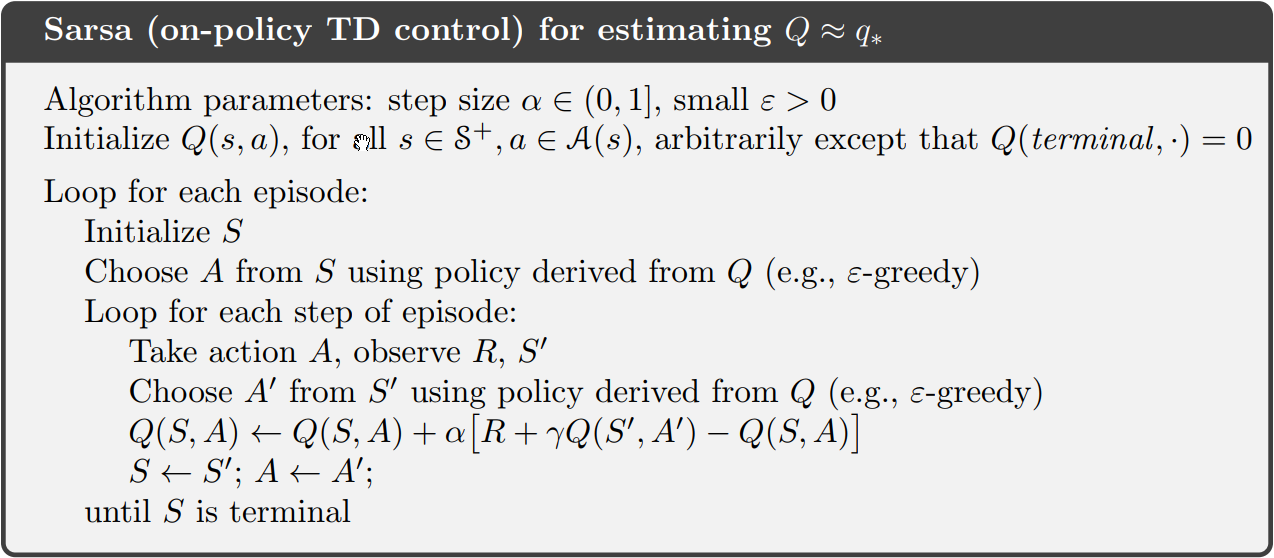

# Python Implementation

**Import Packages**

In [ ]:
import gym
import math
import numpy as np
import matplotlib.pyplot as plt

**Sarsa Agent**

In [ ]:
class Agent:

    def __init__(self, alpha, epsilon, gamma, state_space, action_space, num_actions):

        self.alpha = alpha  # step-size parameter
        self.epsilon = epsilon  # probability of taking a random action in an ε-greedy policy
        self.gamma = gamma  # discount-rate parameter (discount factor)
        self.state_space = state_space
        self.action_space = action_space
        self.num_actions = num_actions

        self.Q = {}
        for s in self.state_space:
            for a in range(self.num_actions):
                self.Q[s, a] = 0

    def policy(self, state):
        """
        Implement the ε-greedy action selection policy.
        """

        q_values = np.array([self.Q[state, a] for a in range(self.num_actions)])
        r = np.random.random()

        if r < self.epsilon:
            action = self.action_space.sample()  # random action - exploration
        else:
            action = np.argmax(q_values)  # greedy action - exploitation

        return action

    def update_values(self, state, action, reward, state_, action_):
        """
        Update the action-value estimates.
        """

        delta = reward + self.gamma * self.Q[state_, action_] - self.Q[state, action]  # TD error
        self.Q[state, action] += self.alpha * delta

    def decrement_epsilon(self, episodes):
        """
        Decrease the value of ε after each episode.
        **Usage is optional.**
        """

        # This is to decrease the probability of taking a random action and ensure convergence with ε-greedy policies.
        # This is because as the action-value estimates change toward the optimal values, the need for exploration
        # decreases and more exploitation is needed.

        if self.epsilon > 0:
            self.epsilon -= 1 / episodes
        else:
            self.epsilon = 0

**Main Body**

In [ ]:
env = gym.make("CartPole-v0")
action_space = env.action_space  # Discrete(2) = [0, 1]
num_actions = 2
# print(env.observation_space.high)
# print(env.observation_space.low)

cart_position_bins = np.linspace(-2.4, 2.4, 19)  # 20 bins/buckets - [-2.4m 2.4m]
cart_velocity_bins = np.linspace(-4, 4, 19)  # 20 bins/buckets
pole_angle_bins = np.linspace(-12 * math.pi / 180, 12 * math.pi / 180, 19)  # 20 bins/buckets - [-12° 12°]
pole_angular_velocity_bins = np.linspace(-4, 4, 19)  # 20 bins/buckets
state_bins = [cart_position_bins, cart_velocity_bins, pole_angle_bins, pole_angular_velocity_bins]

state_space = []
for s1 in range(len(cart_position_bins) + 1):
    for s2 in range(len(cart_position_bins) + 1):
        for s3 in range(len(cart_position_bins) + 1):
            for s4 in range(len(cart_position_bins) + 1):
                state_space.append((s1, s2, s3, s4))


def discretize_obs_space(obs, bins):
    """
    Discretize the continuous observation space.
    """

    cart_position, cart_velocity, pole_angle, pole_angular_velocity = obs

    cart_position = int(np.digitize(cart_position, bins[0], right=False))
    cart_velocity = int(np.digitize(cart_velocity, bins[1], right=False))
    pole_angle = int(np.digitize(pole_angle, bins[2], right=False))
    pole_angular_velocity = int(np.digitize(pole_angular_velocity, bins[3], right=False))

    return cart_position, cart_velocity, pole_angle, pole_angular_velocity


alpha = 0.1  # step-size parameter
epsilon = 1.0  # probability of taking a random action in an ε-greedy policy
gamma = 0.99  # discount-rate parameter (discount factor)

agent = Agent(alpha, epsilon, gamma, state_space, action_space, num_actions)

episodes = 50000
total_rewards = []

for episode in range(1, episodes + 1):

    observation = env.reset()
    state = discretize_obs_space(observation, state_bins)
    action = agent.policy(state)
    done = False

    total_reward = 0
    steps = 0
    # actions = []

    while not done:

        # env.render()
        observation_, reward, done, info = env.step(action)
        state_ = discretize_obs_space(observation_, state_bins)
        action_ = agent.policy(state_)
        agent.update_values(state, action, reward, state_, action_)
        state, action = state_, action_

        total_reward += reward
        steps += 1
        # actions.append(action)

    agent.decrement_epsilon(episodes)
    total_rewards.append(total_reward)

    if episode % 1000 == 0:
        print(f"============ Episode: {episode} ============")
        print(f"Total Reward: {total_reward}")
        print(f"Steps: {steps}")
        # print(f"Actions: {actions}")

# env.close()

**Plot**

In [ ]:
x_axis = [i for i in range(1, episodes + 1)]
y_axis = total_rewards

plt.figure(figsize=(12, 6), dpi=100)

plt.title("Total Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")

plt.plot(x_axis, y_axis)
plt.grid()
plt.show()

**Simulation Results**

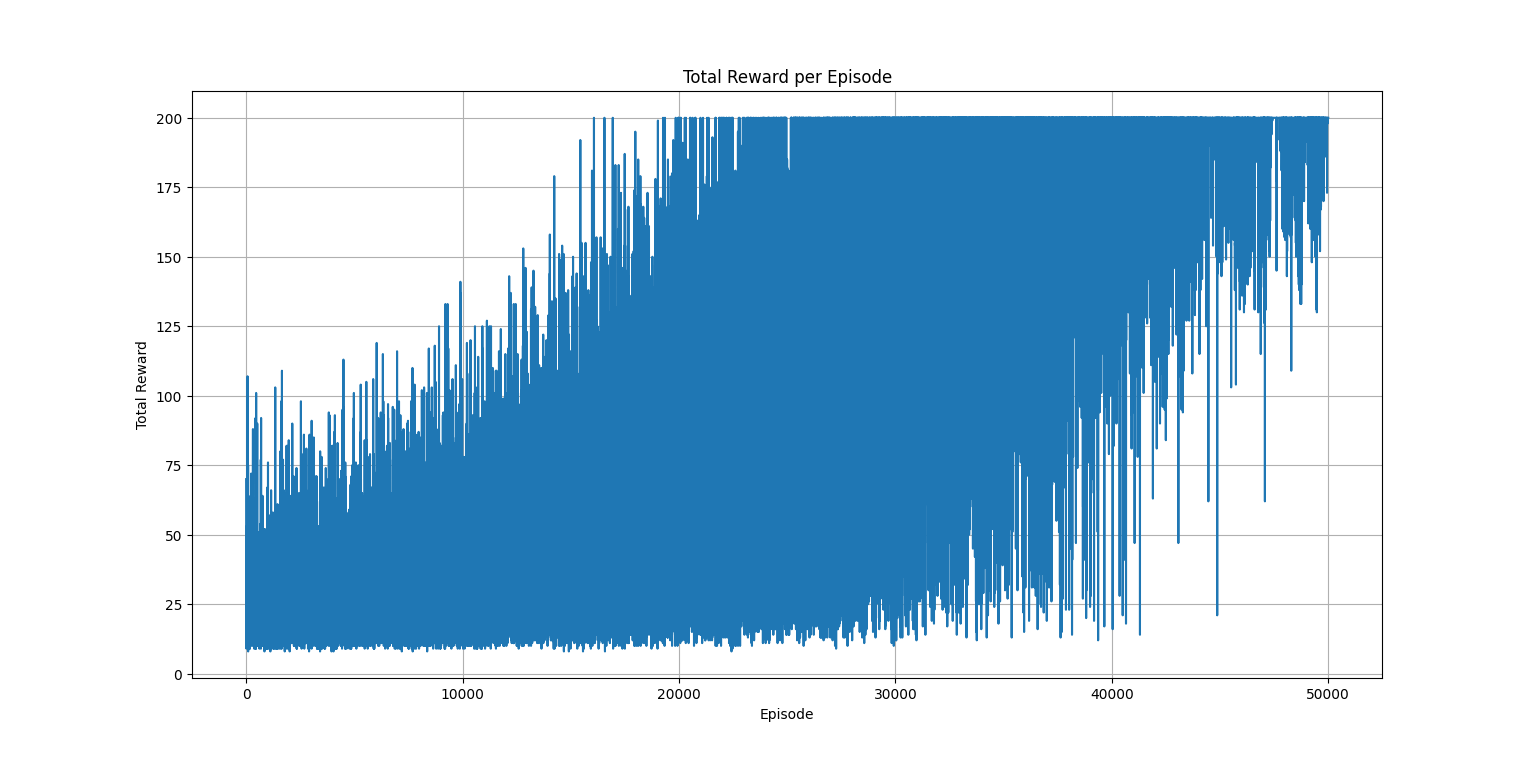